In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
class DiffusionMap:
    def __init__(self, n_eigenvalues, kernel_func, alpha = 1, diffusion_time=1):
        self.n_eigenvalues = n_eigenvalues
        self.kernel_func = kernel_func
        self.diffusion_time = diffusion_time
        self.alpha = alpha


    def create_kernel_matrix(self, data):
        n = len(data)

        row = data.T.reshape(data.shape[1], -1, 1)
        col = data.T.reshape(data.shape[1], 1, -1) 
        
        self.K = self.kernel_func(row, col)
    
    def fit(self, data):
        self.create_kernel_matrix(data)

        D = np.linalg.matrix_power(np.diag(np.sum(self.K, axis=1)), -self.alpha)
        K_alpha = D @ self.K @ D

        D_alpha = np.diag(np.sum(K_alpha, axis=1))

        self.P = np.linalg.inv(D_alpha) @ K_alpha


        self.P = np.linalg.matrix_power(self.P, self.diffusion_time)


        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.P)

        idx = np.argsort(self.eigenvalues)[::-1][1:]
        self.eigenvalues = np.real(self.eigenvalues[idx])
        self.eigenvectors = np.real(self.eigenvectors[:,idx])

        self.components = self.eigenvectors[:,:self.n_eigenvalues]


        return self
    

## Generating Data

In [3]:
# GMM parameters
np.random.seed(0)
n = 2000

epsilons = np.array([.2, .3, .1, .2, .2])
cummulatives = np.cumsum(epsilons)
means = np.array([
    [1, 1],
    [1, 2.5],
    [3, 1],
    [2.25, 2],
    [4, 2.5]
])

covs = np.array([
        [[.1, 0], [0, .1]],
        [[.1, 0], [0, .1]],
        [[.1, 0], [0, .1]],
        [[.15, .05], [.05, .15]],
        [[.1, 0], [0, .1]]
])

data = np.zeros((n, 3))


for i in range(n):
    rand = np.random.rand()
    k = np.sum(cummulatives < rand)

    data[i, :2] = np.random.multivariate_normal(means[k-1], covs[k-1])
    data[i, 2] = k


## Plotting Data

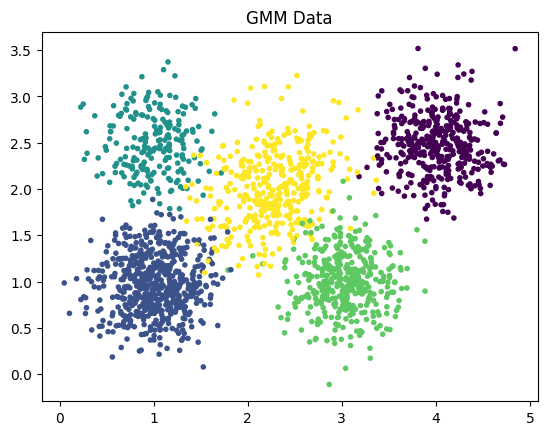

In [4]:
plt.scatter(data[:,0], data[:,1], c=data[:,2], marker='.')
plt.title('GMM Data')
plt.show()

## Diffusion Maps

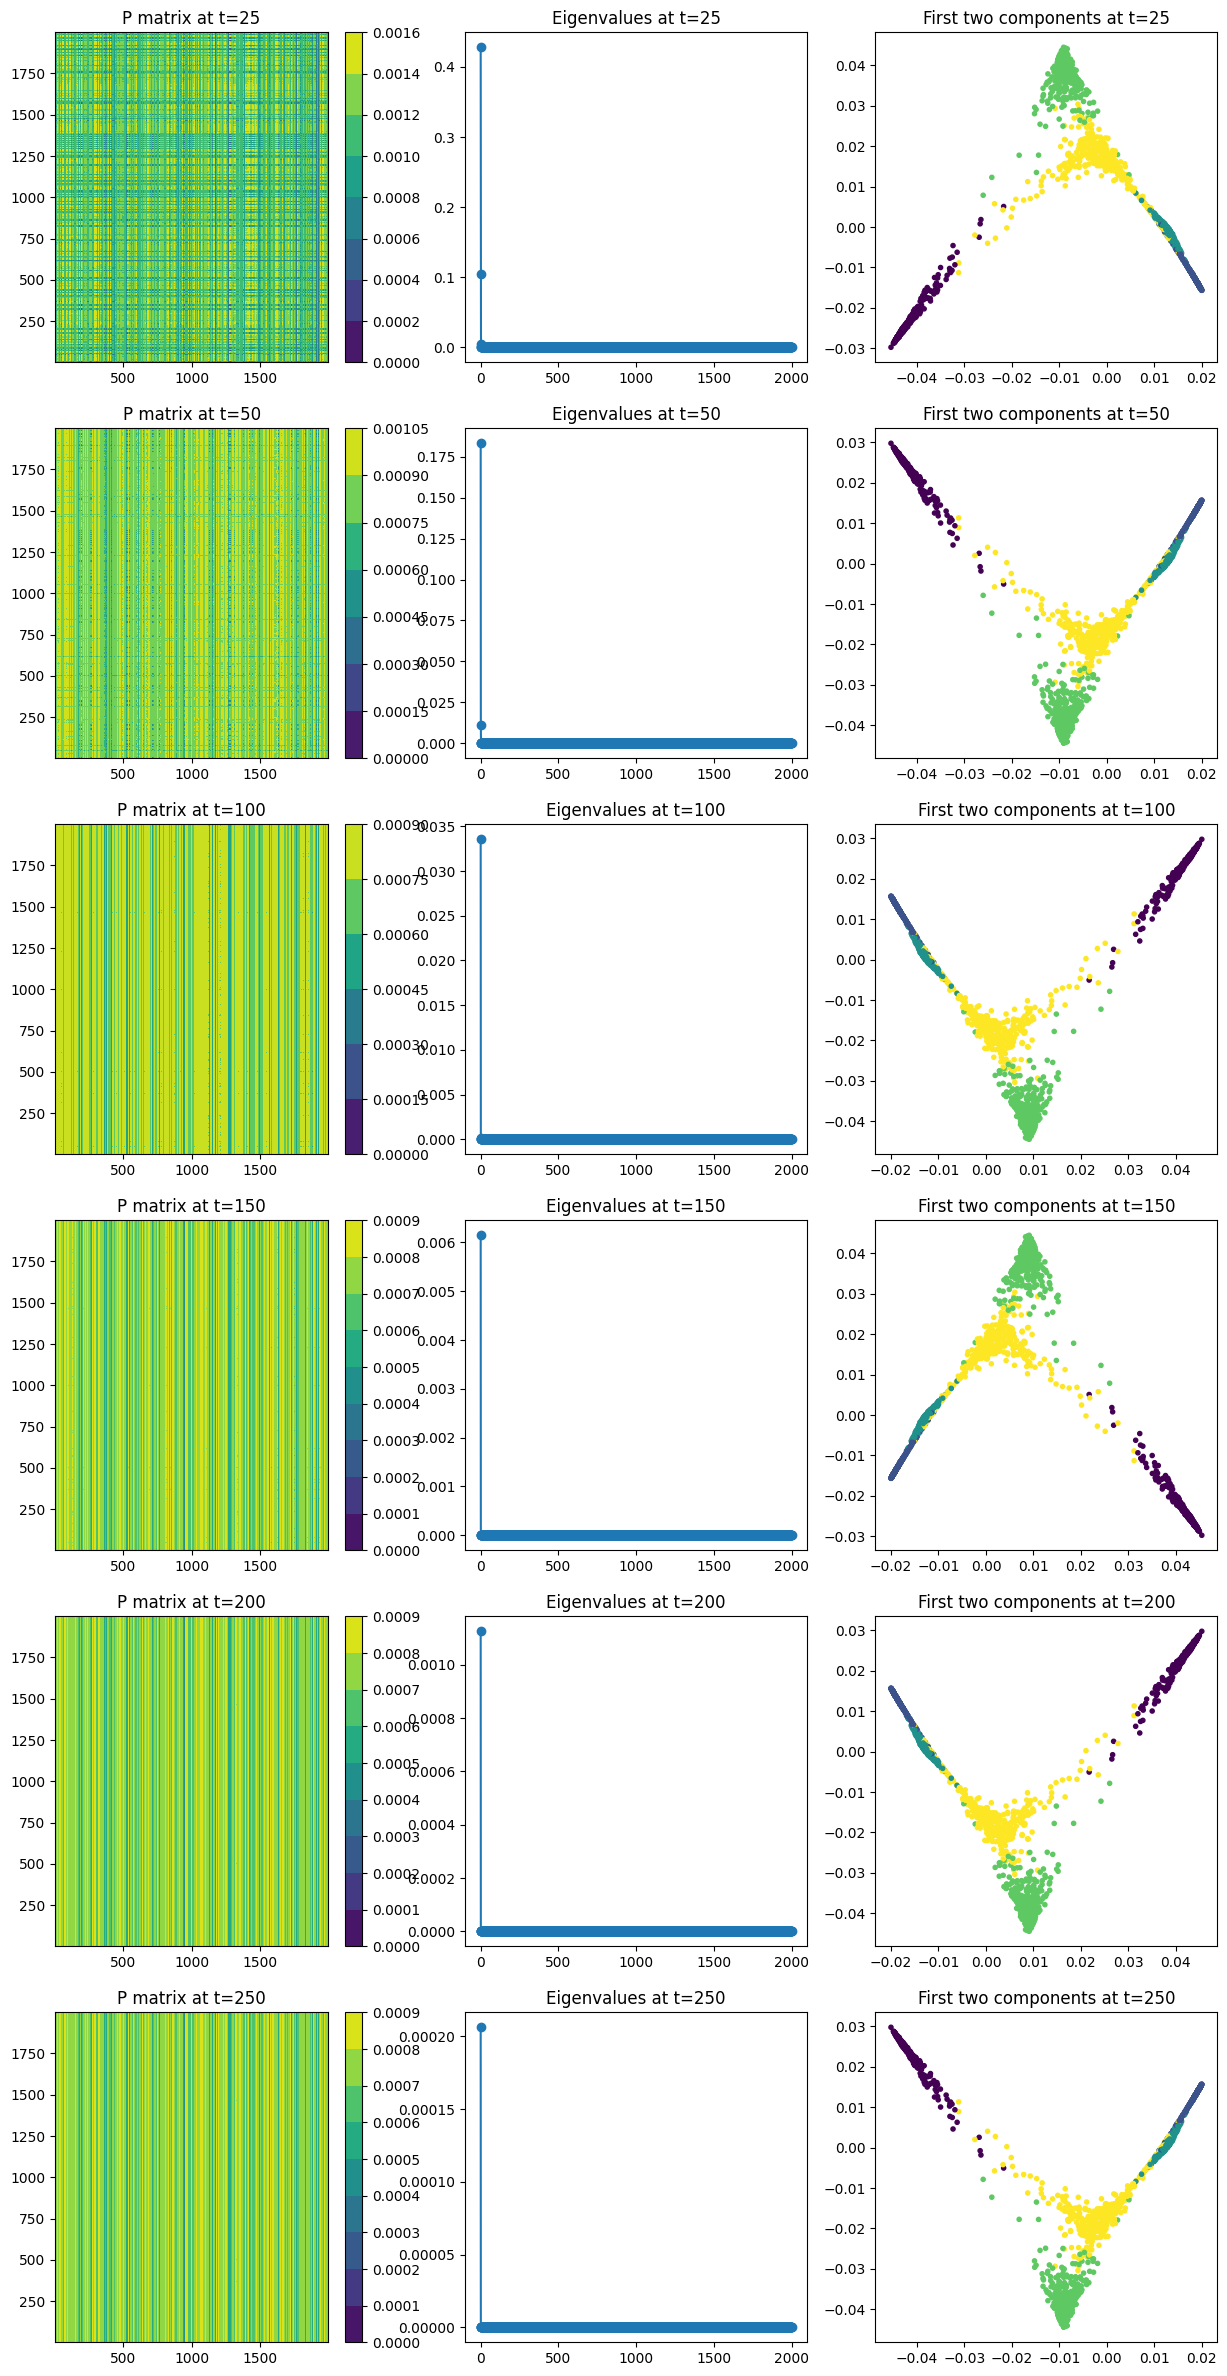

In [9]:
sigma_sq = 0.7**2
t_s = [25, 50, 100, 150, 200, 250]

def rbf(x1, x2):
    return np.exp(-np.linalg.norm(x1 - x2, axis=0)**2/(sigma_sq))

fig, axs = plt.subplots(len(t_s), 3, figsize=(15, 5*len(t_s)))

for i,t in enumerate(t_s):

    dm = DiffusionMap(2, rbf, alpha=0, diffusion_time=t)
    dm = dm.fit(data[:,:2])

    ## Plotting
    c = axs[i][0].contourf(dm.P, origin='upper')

    fig.colorbar(c, ax=axs[i][0])

    axs[i][1].plot(dm.eigenvalues, 'o-')

    axs[i][2].scatter(dm.components[:,0], dm.components[:,1], c=data[:,2], marker='.')

    axs[i][0].set_title(f'P matrix at t={t}')
    axs[i][1].set_title(f'Eigenvalues at t={t}')
    axs[i][2].set_title(f'First two components at t={t}')

plt.show()
